<a href="https://colab.research.google.com/github/ywei6056/Intro.-Experimental-Physics-I-NYU/blob/main/Simulation1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Simulation 1 - Integrating the pendulum differential equation in 1D 

In [ ]:
#run me first
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

##Write a function to do one step of the differential equation

###$F = m a$
If $x(t)$ is the displacement along the arc of the pendulum (almost but not exactly the horizontal displacement), then $x$ obeys this equation of motion 

$m \frac{d^2 x}{d t^2} = - m g \sin(\frac{x}{L})$

If we approximate $\sin(\frac{x}{L})$ as $\frac{x}{L}$ can rewrite this equation as

$\frac{d^2 x}{d t^2} = - \omega^2 x$ ; $\omega^2 = \frac{g}{L}$

### Get rid of the units

When you run computer code, the numbers lose their units. IE t = 3 could be seconds, microseconds, etc. A lot of numerical simulation code tends to work the best when all the numbers are around 1. For both of these reasons, it's usually best to do a change of variables to get rid of as many dimensionful quantities as you can. Here, we want to get rid of the constant $\omega^2$. 

To do this, make a change of variables $s = \omega t$, then $\frac{d}{dt} = \frac{d}{ds}\frac{ds}{dt} = \omega \frac{d}{ds}$ (check that the units work out!)

Then
$\frac{d^2 x}{d s^2} = - x$ 

### Get rid of higer order derivatives

If I know $\frac{dx}{ds} = f(x)$, then I know approximately that $x(s+\Delta s) = x(s) + f(x) \Delta s$ But what do I do with $\frac{d^2x}{ds^2} = g(x)$? The trick is to write down a *system of equations* that only has first derivatives. 

Let me first define

$\frac{d x}{d s} \equiv v$

where $v$ is a new variable. If I knew $v$, I would know that $x(s + \Delta s) = x(s) + v\Delta s$. So now I also need to write down an equation that describes how $v$ changes in time. 

$\frac{d v}{d s} = \frac{d}{d s} (\frac{d x}{d s}) = \frac{d^2 x}{d s^2}$.

From the pendulum equation above, I know that $\frac{d^2 x}{d s^2} = - x$, which means $\frac{d v}{d s} = -x$

So instead of one *second order* differential equation

$\frac{d^2 x}{d s^2} = - x$ 

I would write two *first order* equations:

$\frac{d x}{d s} = v$

$\frac{d v}{d s} = - x$

Then to move forward one small step in time, I would write

$x(s + \Delta s) = x(s) + v* \Delta s$

$v(s + \Delta s) = v(s) - x* \Delta s$

So let's turn this set of equations into a python function

In [ ]:
##finish one line of code to complete this function

def oneLinearPendulumStep(x, v, ds):
  #x is the position at time s
  #v is the velocity at time s
  #returns position and velocity at time s + ds according to
  #x(s+ds) = x(s) + v ds
  #v(s+ds) = v(s) - x ds

  xout = x + v * ds
  vout = v - x*ds

  return (xout, vout)

##Integrate the differential equation
So now we seem to have a simple path forward to solve the pendulum ode

1. Start with intital x0, v0 at s = 0
1. Run oneLinearPendulum step to find x(ds),v(ds)
  1. Repeat to find x(2ds),v(2ds) 
  1. Repeat to find x(3ds),v(3ds)
  1. Continue repeating until you have made it to N ds where N ds = S is how long (in non-dimensional time*) you want to simulate
1. As you go, store the results in an array so you can plot them later

*What is the relation between S and real time? If I want to simulate 10 periods, what is the value of S I should go to?

Let's go ahead and do this and see what happens

In [ ]:

def simulatePendulumBasic (x0, v0, ds, S):
  #simulates the motion of a pendulum starting with x(0) = x0, v(0) = v0, in time steps of ds from 0 to S
  #returns (x, v, s)
  N = int(np.ceil(S/ds)) #calculate number of steps

  #initialize memory storage
  x = np.zeros(N)
  v = np.zeros(N)
  s = np.zeros(N)

  x[0] = x0
  v[0] = v0
  for j in range(1,N):
    s[j] = s[j-1] + ds
    x[j] = x[j-1]+(v[j-1])*ds
    v[j]= v[j-1] -(x[j-1])*ds

  return (x,v,s)



Let's test out your function by running the following block, which will calculate the numeric solution over one period in steps of 0.001 and plot the numeric and analytic ($x = \cos(s)$) solutions together

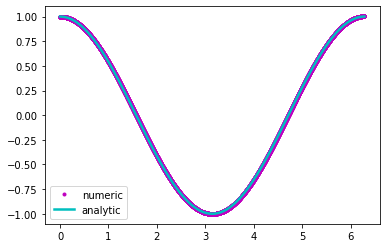

In [ ]:
##test your function by running this code block; if it works you should see that the analytic solution matches the numerical solution
[x,v,s] = simulatePendulumBasic(1,0,.001,2*np.pi)
plt.plot(s,x,'m.',s,np.cos(s),'c-', LineWidth = 2.5)
plt.legend(('numeric','analytic'))

Now I want you to do the same thing, but instead of solving for one period, solve for 500 periods, in steps of ds = 0.001. What happens? 

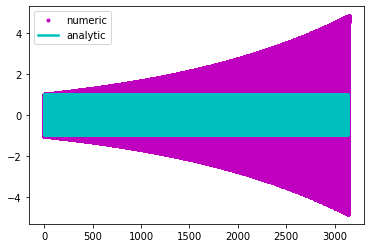

In [ ]:
[x,v,s] = simulatePendulumBasic(1,0,.001,1000*np.pi)
plt.plot(s,x,'m.',s,np.cos(s),'c-', LineWidth = 2.5)
plt.legend(('numeric','analytic'))

#Use the scipy numerical integrator

OK, so it looks like the simple approach has some issues with stability. Fortunately, there's a whole body of work on how to do numeric integration without these little blow ups. And even more fortunately, Python includes code that does exactly this. 

Scipy includes a function called [solve ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) 

Solve ivp stands for solve initial value problem; you give it a differential equation and the initial values (e.g. of position and velocity) and it finds all future values

From the documentation: This function numerically integrates a system of ordinary differential equations given an initial value:

$\frac{d \vec{y}}{d t} = f(t,\vec{y})$

$\vec{y}(t_{init}) = \vec{y}_{init}$

Here I've written $y$ as a vector, $\vec{y}$ to emphasize that there may be more than one y value in the solution. $t_{init}$ is the initial time, which is usually 0, but doesn't have to be. 

Moving forward, although the documentation uses $t$ for time, I'm going to use $s$, to keep track of the fact that we'll make time non-dimensional ($s = \omega t$) before we plug it into the solver.

How do we turn our two values (position and velocity) into a vector? In our pendulum example, we would begin with our system of equations

$\frac{d x}{d s} = v(s)$

$\frac{d v}{d s} = - x(s)$

$x(s_{init}) = x_{init}$

$v(s_{init}) = v_{init}$

and we would just arbitrarily (although this is also very conventional) say 

$\vec{y}(s) = (x(s),v(s))$

$\vec{y}_{init} = (x_{init},v_{init})$

Then we can write 

$\frac{d \vec{y}}{d s} = (\frac{d x}{d s}, \frac{d v}{d s}) = (v(s),-x(s)) = (y_1(s), -y_0(s))$

So if $\frac{d \vec{y}}{d t} = f(t,\vec{y})$, then

$f(s,\vec{y}) = (y_1(s), -y_0(s))$

Note that even though $s$ appears on the left side, it doesn't appear by itself on the right. This is because our specific equations of motion don't have explicit time dependence. An example where $s$ would appear on the right is if we were applying a periodic force by pushing the pendulum at particular times (we won't do that yet!). **Even if your derivative function doesn't use s, you have to include both arguments in the function definition**

####Mapping between math notation and python notation

In math, I write $\vec{y}(s) = (y_0(s), y_1(s))$ to indicate I have two components of the vector $\vec{y}$, each of which depends on s. Sometimes I write $\vec{y} = (y_0, y_1)$, and the s-dependece is understood. When I turn this into python notation, the $(s)$ is always understood, and I write the first component as ```y[0]``` and the second component as ```y[1]```

In math, I write

$\frac{d \vec{y}}{d s} = f(s,\vec{y})$

$f(s,\vec{y}) = (y_1, -y_0)$


In python, I write

``` pendulum_derivative_function (t_unused,y): return (y[1],-y[0])```

At a minimum solve ivp takes 3 inputs and returns an output "bunch object" which just basically stores all the parts of the answer by name:


```
sol = solve_ivp(fun, t_span, y0)
#fun is the derivative function dydt = fun(t,y)
#t_span is (initial_time, final_time)
#y0 is the initial condition

#sol.t has the time value
#sol.y has the solution
plt.plot(sol.t, sol.y[0]) #would plot position vs. time, if y[0] represents position
```

Below is a minimum working example so you can see how to use the numerical integrator - you don't have to edit this code

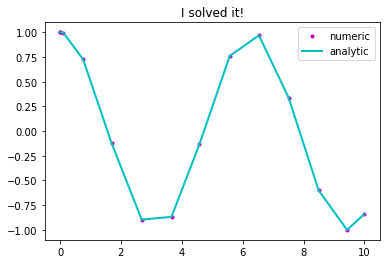

In [ ]:
def pendulum_derivative_function (t_unused,y): return (y[1],-y[0]) #y[0] = position, y[1] = velocity; encodes relation dposition/dt = velocity, dvelocity/dt = -position
y0 = (1,0) #initial position = 1, initial velocity = 0 - should look like a cosine
t_span = (0,10) #go from s = 0 to s = 10
sol = solve_ivp(pendulum_derivative_function, t_span, y0)
plt.plot(sol.t, sol.y[0], 'm.', sol.t, np.cos(sol.t), 'c-', LineWidth = 2)
plt.legend(('numeric','analytic'))
plt.title('I solved it!'); 

### Well that doesn't look so good! 
What happened? By default, the solver spaces the output time points too far apart. How do we fix this? By telling the solver exactly when we want the output.
From the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html), we find the optional parameter: 

**t_eval : array_like or None, optional**

Times at which to store the computed solution, must be sorted and lie within t_span. If None (default), use points selected by the solver.

So let's define a time axis with a small increment for the solver to use for output. Look over this code and run it - you don't have to edit anything. 

**look at how I used ```t_eval``` below** This is an example of how you use *keyword arguments* in Python. You will need to use keyword arguments to solve the next part. 

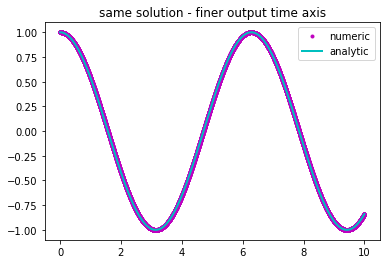

In [ ]:

ds = 0.001
sol = solve_ivp(pendulum_derivative_function, t_span, y0, t_eval = np.arange(t_span[0],t_span[1],ds))
plt.plot(sol.t, sol.y[0], 'm.', sol.t, np.cos(sol.t), 'c-', LineWidth = 2)
plt.legend(('numeric','analytic'))
plt.title ('same solution - finer output time axis'); 

##Now your turn
Solve the following intial value problem numerically

$\frac{d^2x}{dt^2} = -x$

$x(0) = 0.1$

$\frac{dx}{dt}(0) = 0$

in the time range (0,1000) (this is ```t_span```)

Plot the numeric solution from t = 990 to t = 1000 in increments of 0.001 (this is ```t_eval```) along with the analytic solution ($x(t) = 0.1 \cos(t)$) over the same range. Add a legend indicating "numeric" and "analytic"


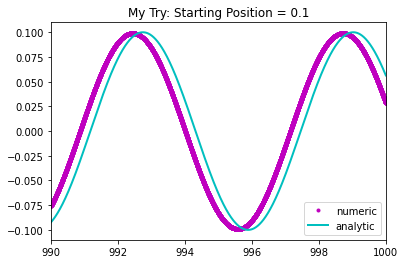

In [ ]:
def pendulum_derivative_function (t_unused,y): return (y[1],-y[0]) 
y0 = (.1,0)

ds = 0.001
t_span=(0,1000)

sol = solve_ivp(pendulum_derivative_function, t_span, y0, t_eval = np.arange(t_span[0],t_span[1],ds))
plt.plot(sol.t, sol.y[0], 'm.', sol.t, 0.1*(np.cos(sol.t)), 'c-', LineWidth = 2)
plt.xlim(990, 1000)

plt.legend(('numeric','analytic'))
plt.title ('My Try: Starting Position = 0.1'); 








#More solver options - algorithm and precision
OK, so if you did what I did, you'll see that by the time you get to s = 1000, then numeric solution has diverged slightly from the analytic solution. It didn't blow up like before, but there is a phase shift - the numeric solution gets a little bit ahead. 

What can we do to fix these problems?

The solver offers a bunch of choices for algorithms. The default is 'RK45' which is an `Explicit Runge-Kutta method of order 5.' Another choice is ‘DOP853’: Explicit Runge-Kutta method of order 8. 8 is bigger than 5, so let's try that!

Rewrite your code adding the keyword argument
```
method = 'DOP853'
```
to the solver call

Plot the new solution along with the analytic (cosine) solution from time 990 to 1000 in steps of 0.001

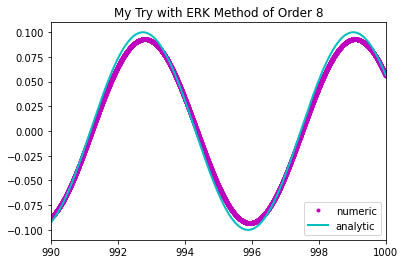

In [ ]:
def pendulum_derivative_function (t_unused,y): return (y[1],-y[0]) 
y0 = (.1,0)

ds = 0.001
t_span=(0,1000)

sol = solve_ivp(pendulum_derivative_function, t_span, y0, t_eval = np.arange(t_span[0],t_span[1],ds), method='DOP853')
plt.plot(sol.t, sol.y[0], 'm.', sol.t, 0.1*(np.cos(sol.t)), 'c-', LineWidth = 2)
plt.xlim(990, 1000)

plt.legend(('numeric','analytic'))
plt.title ('My Try with ERK Method of Order 8'); 


You can tell the solver how much error (estimated by the solver) you are willing to tolerate using the 'rtol' and 'atol' arguments. 'rtol' is the relative tolerance (dy/y) while 'atol' is the absolute tolerance (dy). The defaults are 'rtol' = 1e-3 and 'atol' = 1e-6. Since the errors are at each step of the solver, they can accumulate over time. Try again adding the flags
```
rtol = 1e-9, atol = 1e-9
```

Text(0.5, 1.0, 'My Try with ERK Method of Order 8 and Error Bounds')

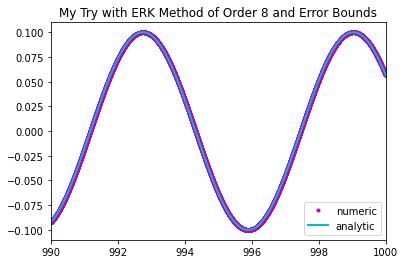

In [ ]:
def pendulum_derivative_function (t_unused,y): return (y[1],-y[0]) 
y0 = (.1,0)

ds = 0.001
t_span=(0,1000)

sol = solve_ivp(pendulum_derivative_function, t_span, y0, t_eval = np.arange(t_span[0],t_span[1],ds), method='DOP853', rtol = 1e-9, atol = 1e-9)
plt.plot(sol.t, sol.y[0], 'm.', sol.t, 0.1*(np.cos(sol.t)), 'c-', LineWidth = 2)
plt.xlim(990, 1000)

plt.legend(('numeric','analytic'))
plt.title ('My Try with ERK Method of Order 8 and Error Bounds')

Now try using the implicit methods 'BDF' and 'Radau.' Make separate plots for each (along with the cos solution) and title the plots with the name of the method. Leave rtol and atol at their default values


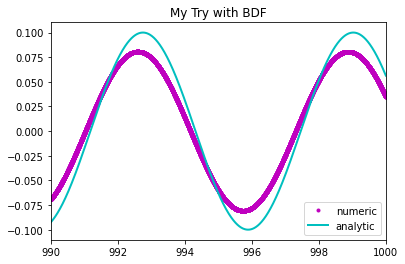

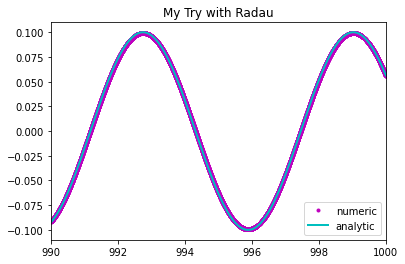

In [ ]:
def pendulum_derivative_function (t_unused,y): return (y[1],-y[0]) 
y0 = (.1,0)

ds = 0.001
t_span=(0,1000)

sol = solve_ivp(pendulum_derivative_function, t_span, y0, t_eval = np.arange(t_span[0],t_span[1],ds), method='BDF')
plt.plot(sol.t, sol.y[0], 'm.', sol.t, 0.1*(np.cos(sol.t)), 'c-', LineWidth = 2)
plt.xlim(990, 1000)

plt.legend(('numeric','analytic'))
plt.title ('My Try with BDF')
plt.show() 

sol = solve_ivp(pendulum_derivative_function, t_span, y0, t_eval = np.arange(t_span[0],t_span[1],ds), method='Radau')
plt.plot(sol.t, sol.y[0], 'm.', sol.t, 0.1*(np.cos(sol.t)), 'c-', LineWidth = 2)
plt.xlim(990, 1000)

plt.legend(('numeric','analytic'))
plt.title ('My Try with Radau')
plt.show() 



###Compare DOP853 and Radau

Solve the system using the DOP853 and Radau fitters with rtol and atol = 1e-9. From each fit subtract off the true cosine solution and plot the difference in the time window 990 to 1000 in steps of 0.001.

When you run the cell, there will be a little green arrow the left of the command that's running. Pay attention to which command takes the longest. Does the more accurate solver end up taking longer to run?


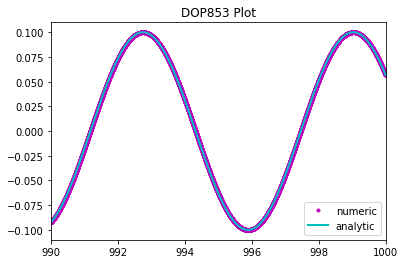

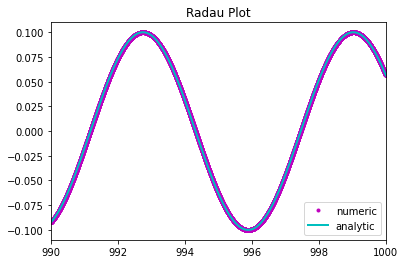

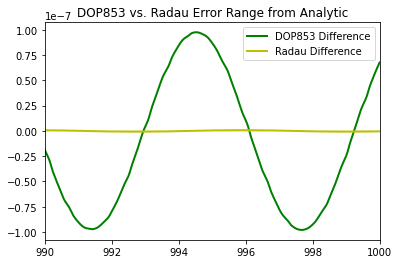

In [ ]:
sol_DOP = solve_ivp(pendulum_derivative_function, t_span, y0, t_eval = np.arange(t_span[0],t_span[1],ds), method='DOP853', rtol = 1e-9, atol = 1e-9)
plt.plot(sol_DOP.t, sol_DOP.y[0], 'm.', sol_DOP.t, 0.1*(np.cos(sol_DOP.t)), 'c-', LineWidth = 2)
plt.xlim(990, 1000)
plt.legend(('numeric','analytic'))
plt.title ('DOP853 Plot')
plt.show()

sol_Radau = solve_ivp(pendulum_derivative_function, t_span, y0, t_eval = np.arange(t_span[0],t_span[1],ds), method='Radau', rtol = 1e-9, atol = 1e-9)
plt.plot(sol_Radau.t, sol_Radau.y[0], 'm.', sol_Radau.t, 0.1*(np.cos(sol_Radau.t)), 'c-', LineWidth = 2)
plt.xlim(990, 1000)
plt.legend(('numeric','analytic'))
plt.title ('Radau Plot')
plt.show() 

plt.plot(sol_DOP.t, (sol_DOP.y[0])-(0.1*(np.cos(sol_DOP.t))), 'g', sol_Radau.t, (sol_Radau.y[0])-(0.1*(np.cos(sol_Radau.t))), 'y', LineWidth = 2)
plt.xlim(990, 1000)
plt.legend(('DOP853 Difference', 'Radau Difference'))
plt.title ('DOP853 vs. Radau Error Range from Analytic')
plt.show()

#Asnwer: The Radau graph takes longer to run.

#Now let's calcuate the period

As you know from doing your measurements, you can define the period as the time between two zero crossings both headed in the same direction. You could look back at your solution and try to find all the times when y[0] crosses 0 from negative to positive, but the solver actual provides a way to do this with the keyword argument events

**events : callable, or list of callables, optional**

Events to track. If None (default), no events will be tracked. Each event occurs at the zeros of a continuous function of time and state. Each function must have the signature event(t, y) and return a float. The solver will find an accurate value of t at which event(t, y(t)) = 0 using a root-finding algorithm. By default, all zeros will be found. The solver looks for a sign change over each step, so if multiple zero crossings occur within one step, events may be missed. Additionally each event function might have the following attributes:

terminal: bool, optional

Whether to terminate integration if this event occurs. Implicitly False if not assigned.

direction: float, optional

Direction of a zero crossing. If direction is positive, event will only trigger when going from negative to positive, and vice versa if direction is negative. If 0, then either direction will trigger event. Implicitly 0 if not assigned.

You can assign attributes like event.terminal = True to any function in Python.



This is a whole lot to read, so I'm just going to write the function for you

```
def pos_zcr (t,y): return y[0]
pos_zcr.direction = 1
```

if you pass 
```
events = pos_zcr
```
to the solver, then the times of all the positive zero crossings will be stored in sol.t_events. The average spacing between these times is the period. Let me show you how it works


In [ ]:
def pos_zcr (t,y): return y[0]
pos_zcr.direction = 1
sol = solve_ivp(pendulum_derivative_function, (0,100), y0,events = pos_zcr)
print ("period is: ", np.mean(np.diff(sol.t_events)))
print ("period/pi is: ", np.mean(np.diff(sol.t_events))/np.pi)
print ("fractional error is: ", (np.mean(np.diff(sol.t_events))-2*np.pi)/(2*np.pi))


period is:  6.281237342484072
period/pi is:  1.9993799435794808
fractional error is:  -0.0003100282102595614


Now you take a try playing with the solver options (e.g. rtol, atol, using different it methods). See if you can get the fractional error under 10^-8. 

In [ ]:
def pos_zcr (t,y): return y[0]
pos_zcr.direction = 1
sol = solve_ivp(pendulum_derivative_function, (0,100), y0, events = pos_zcr, method='Radau', rtol = 1e-9, atol = 1e-9)
print (f'period is:{np.mean(np.diff(sol.t_events))} RADIANS because we used the S value for T') #and s is from omega*t, which is in units of radians. AHHH
print (f'period/pi is: {np.mean(np.diff(sol.t_events))/np.pi} seconds')
print ("fractional error is: ", (np.mean(np.diff(sol.t_events))-2*np.pi)/(2*np.pi))

period is:6.283185307179845 RADIANS because we used the S value for T
period/pi is: 2.000000000000082 seconds
fractional error is:  4.1135173880261485e-14


Now write a function ```numerical_period(amplitude)``` that calculates the period to a relative accuracy of at least 10^-8 for a given amplitude of the pendulum. (If amplitude = a, then start with y0 = (a,0)). Use this function to calculate the period for a starting amplitude of 0.01, 0.1, and 1. Does the period depend on amplitude? 

In [ ]:
def pos_zcr (t,y): return y[0]
pos_zcr.direction = 1
def numerical_period(amplitude):
  y0 = (amplitude, 0)
  sol = solve_ivp(pendulum_derivative_function, (0,100), y0, events = pos_zcr, method='Radau', rtol = 1e-9, atol = 1e-9)
  numerical_period = np.mean(np.diff(sol.t_events))
  return(numerical_period)

print(numerical_period(0.01))
print(numerical_period(0.1))
print(numerical_period(1))

print('Answer: no, since the difference between the three periods is less than the 10E-8 fractional error. ')

6.283185307186704
6.283185307179845
6.283185307179724
Answer: no, since the difference between the three periods is less than the 10E-8 fractional error. 


#Now, let's find how the period of the *real pendulum* changes with length 

The real pendulum obeys the differential equation

$\frac{d^2 \theta}{d t^2} = -\omega^2 \sin(\theta)$

where

$\theta = \frac{x}{L}$


If the pendulum has amplitude $a$, you can rewrite this as an initial value problem

$\frac{d \theta}{d s} = \dot{\theta}$

$\frac{d \dot{\theta}}{d s} = -\sin(\theta)$

$\theta(0) = \frac{a}{L}$

$\dot{\theta}(0) = 0$

$s = \omega t$

Please do the following:

1. Write a derivative function ```real_pendulum_derivative_function``` that modifies ```pendulum_derivative_function``` 
1. Find the solution to the initial value problem with amplitude $\frac{a}{L} = 0.3$ over the time range s = 0 to 30 in increments of 0.001. 
  1. Plot the solution along with the linearized solution $0.3 \cos(s)$
  1. On a separate graph, plot the real solution minus the linearized solution ($0.3 \cos(s)$)
1. Write a function that finds the period of the real pendulum as a function of amplitude
1. Calculate the period/$2 \pi$ vs. $\frac{a}{L}$ for a = (0.01 to .3) in steps of 0.01. 
  1. Store the calculated periods in a numpy array called ```period``` and store the range of amplitudes in a numpy array called ```amplitude```
  1. Plot period/$2\pi$ vs. amplitude (Hint, do the plotting excercises in a different cell from the calculations so you don't have to keep rerunning the time consuming bits)
  1. Define ```rdp``` (relative delta p) as $\frac{period - 2\pi}{2\pi}$. 
  1. On a new plot, plot rdp (with blue circles) vs. amplitude. On the same plot, plot the curve $\frac{1}{16}$ amplitude$^2$ as a red line. 
  1. *Optional Challenge:* use [np.polyfit](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html) to fit the relation between rdp and amplitude. Is the relation rdp = $\frac{1}{16}$ amplitude$^2$ correct?
  1. Based on your simulations, predict the change in the period of *your pendulum* if you measure it at an amplitude of 10 cm vs. 5 cm.  

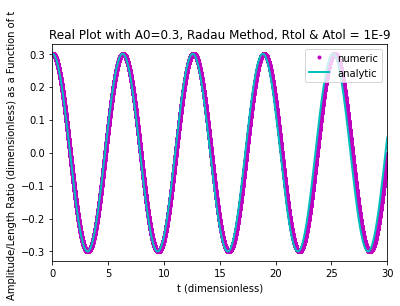

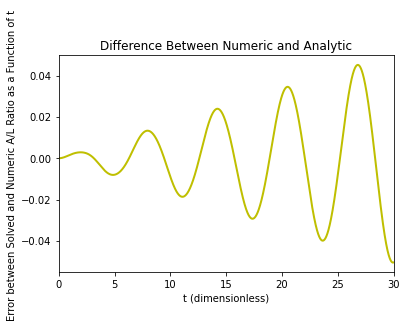

In [ ]:
#1, 2.1
def pendulum_real(t_unused,y): return (y[1],-np.sin(y[0])) 
y0 = (0.3, 0)
ds = 0.001
t_span=(0,30)

sol_real = solve_ivp(pendulum_real, t_span, y0, t_eval = np.arange(t_span[0],t_span[1],ds), method='Radau', rtol = 1e-9, atol = 1e-9)
plt.plot(sol_real.t, sol_real.y[0], 'm.', sol_real.t, 0.3*(np.cos(sol_real.t)), 'c-', LineWidth = 2)
plt.xlim(0,30)
plt.legend(('numeric','analytic'), loc='upper right')
plt.title ('Real Plot with A0=0.3, Radau Method, Rtol & Atol = 1E-9')
plt.xlabel('t (dimensionless)')
plt.ylabel('Amplitude/Length Ratio (dimensionless) as a Function of t ')
plt.show() 

#2.2
plt.plot(sol_real.t, (sol_real.y[0])-(0.3*(np.cos(sol_real.t))), 'y', LineWidth = 2 )
plt.xlim(0,30)
plt.title ('Difference Between Numeric and Analytic')
plt.xlabel('t (dimensionless)')
plt.ylabel('Error between Solved and Numeric A/L Ratio as a Function of t ')
plt.show() 

#3
def real_period(Amplitude):
  y0=(Amplitude, 0)
  sol_real = solve_ivp(pendulum_real, (0,100), y0, events = pos_zcr, method='Radau', rtol = 1e-9, atol = 1e-9)
  numerical_period = np.mean(np.diff(sol_real.t_events))/(2*np.pi)
  return(numerical_period)

#4.0
amplitude = np.arange(0.01, 0.31, 0.01)
period = []
for i in amplitude:
  p = real_period(i)
  period.append(p)

period = np.array(period)

#4.1
#done



In [ ]:
print(len(period))
print(type(period))

30
<class 'numpy.ndarray'>


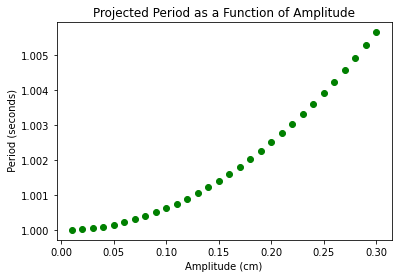

[6.25003686e-06 2.50005750e-05 5.62529009e-05 1.00009167e-04
 1.56272383e-04 2.25046417e-04 3.06336001e-04 4.00146728e-04
 5.06485056e-04 6.25358307e-04 7.56774670e-04 9.00743201e-04
 1.05727383e-03 1.22637734e-03 1.40806542e-03 1.60235061e-03
 1.80924634e-03 2.02876691e-03 2.26092751e-03 2.50574423e-03
 2.76323403e-03 3.03341477e-03 3.31630522e-03 3.61192503e-03
 3.92029478e-03 4.24143592e-03 4.57537086e-03 4.92212290e-03
 5.28171626e-03 5.65417611e-03]


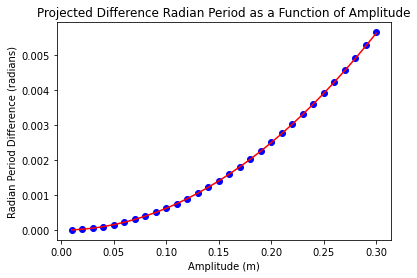

In [ ]:
#4.2
plt.plot(amplitude, period, 'go')
plt.xlabel('Amplitude (cm)')
plt.ylabel(' Period (seconds)')
plt.title('Projected Period as a Function of Amplitude')
plt.show()

#4.3
rdp=(period*2*np.pi - np.pi*2)/(np.pi*2)
print(rdp)

#4.4
plt.plot(amplitude, rdp, 'bo', amplitude, (1/16)*(amplitude)**2, 'r')
plt.xlabel('Amplitude (m)')
plt.ylabel('Radian Period Difference (radians)')
plt.title('Projected Difference Radian Period as a Function of Amplitude')
plt.show()

#4.5
#fit = np.polyfit(amplitude, (rdp, (1/16)*(amplitude)**2), deg=3)
#not sure how to do



In [ ]:
#4.6
#Based on your simulations, predict the change in the period of YOUR pendulum if you measure it at an amplitude of 10 cm vs. 5 cm
rdp_5cm = (1/16)*(0.05)**2
rdp_10cm = (1/16)*(0.10)**2

#our period (from Lab 2, very small amplitude ~=0) was 2.077648 seconds.
mean_C = 2.077648
MCRad = mean_C*np.pi

predicted_5cm = MCRad + rdp_5cm
predicted_10cm = MCRad + rdp_10cm

print(predicted_5cm)
print(predicted_10cm)

numerical_change = (predicted_10cm - predicted_5cm)/np.pi

print(f'The change to 10cm amplitude from 5cm amplitude increases predicted period by {numerical_change} seconds.')

6.527279943545526
6.527748693545527
The change to 10cm amplitude from 5cm amplitude increases predicted period by 0.0001492077591487989 seconds.
